<a href="https://colab.research.google.com/github/CaioWing/Bootcamp-InovaUSP/blob/main/desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ordem Esperada para as classes no dataset de recicláveis:

- Class 0: bottle-blue
- Class 1: bottle-blue-full
- Class 2: bottle-blue5l
- Class 3: bottle-blue5l-full
- Class 4: bottle-dark
- Class 5: bottle-dark-full
- Class 6: bottle-green
- Class 7: bottle-green-full
- Class 8: bottle-milk
- Class 9: bottle-milk-full
- Class 10: bottle-multicolor
- Class 11: bottle-multicolorv-full
- Class 12: bottle-oil
- Class 13: bottle-oil-full
- Class 14: bottle-transp
- Class 15: bottle-transp-full
- Class 16: bottle-yogurt
- Class 17: glass-dark
- Class 18: glass-green
- Class 19: glass-transp
- Class 20: canister
- Class 21: cans
- Class 22: juice-cardboard
- Class 23: milk-cardboard
- Class 24: detergent-box
- Class 25: detergent-color
- Class 26: detergent-transparent
- Class 27: detergent-white


#### Download do Dataset

Neste exemplo estamos usando o dataset [Fruits and Vegetables Image Recognition Dataset](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition), disponível sob a licensa [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/).

Por estar disponível sob uma licensa de domínio público, podemos fazer basicamente o que quisermos com esse dataset, inclusive redistribuir ele.


O dataset a ser usado na avaliação está disponível em:

- Treinamento: https://docs.toradex.com/private/114105-recyclables_train.zip​
- Validação: https://docs.toradex.com/private/114106-recyclables_validation.zip

In [1]:
# Baixar e descompactar o dataset
!mkdir dataset
!wget -q https://docs.toradex.com/private/114106-recyclables_validation.zip \
         https://docs.toradex.com/private/114105-recyclables_train.zip​
!unzip -q '*.zip' -d dataset/
# Definir o caminho do dataset
data_path = "dataset"

mkdir: cannot create directory ‘dataset’: File exists
replace dataset/validation_crops/canister/canister/POSAD_1_13-Sep_04-23-53_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/validation_crops/canister/canister/POSAD_1_13-Sep_04-23-53_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
!unzip -q '/content/114105-recyclables_train.zip​' -d dataset/

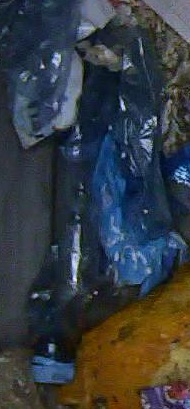

In [6]:
from IPython.display import Image
Image("/content/dataset/train_crops/bottle/bottle-blue/Monitoring_photo1_04-Mar_03-09-16_01.jpg", width=256)


In [7]:
# Instalar Pytorch, Torchvision, Tensorboard e utilidades parar ver o progresso do treinamento
!pip install -q torch torchvision torcheval tensorboard matplotlib tqdm tensorflow ipywidgets seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.6 MB/s eta 0:00:00


In [8]:
# Módulos, classes e funções que são úteis para inferência e treinamento
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torcheval.metrics import MulticlassF1Score, MulticlassRecall, MulticlassPrecision

# Suporte a TensorBoard no PyTorch
from torch.utils.tensorboard import SummaryWriter

# Utiliades do sistema
from datetime import datetime
import time
import os

# O Tqdm é utilizado para criar barras de progresso
from tqdm.notebook import tqdm


print(torch.__version__)

2.1.0+cu118


In [21]:
list_paths = [
    "/content/dataset/train_crops/bottle",
    "/content/dataset/train_crops/canister",
    "/content/dataset/train_crops/cans",
    "/content/dataset/train_crops/cardboard",
    "/content/dataset/train_crops/detergent"
]

def get_paths(
    root_paths : list[str]
):
#ler tudo que esta dentro do path raiz, pegar o nome da pasta como classe, e relacionar do path da imagem
  all_data = []
  index = 0

  def get_images(class_path, index):
    images = []
    class_images = os.listdir(class_path)
    for image in class_images:
      if(not (image.endswith(".jpg") or image.endswith(".JPG") or image.endswith(".png") or image.endswith(".PNG"))):
          continue
      image_path = os.path.join(class_path, image)
      #tuple -> path da imagem e um index referente a classe
      images.append((image_path, index))
      return images

  for root_path in root_paths:
    initial_paths = root_path + os.listdir(root_path)
    for class_path in initial_paths:
      all_data.append(get_images(class_path, index))
      index += 1
  return all_data

os.listdir(list_paths[0])

['bottle-oil',
 'bottle-oil-full',
 'bottle-dark-full',
 'bottle-green-full',
 'bottle-milk',
 'bottle-yogurt',
 'glass-dark',
 'bottle-multicolor',
 'bottle-blue5l',
 'bottle-blue-full',
 'glass-transp',
 'bottle-blue5l-full',
 'bottle-milk-full',
 'bottle-transp',
 'bottle-transp-full',
 'bottle-blue',
 'glass-green',
 'bottle-green',
 'bottle-multicolorv-full',
 'bottle-dark']

In [22]:
get_paths(list_paths)

TypeError: ignored

In [ ]:
# Declaração da classe herdando de Dataset
class CustomDataset(Dataset):

    # Construtor
    def __init__(self, images_dir, preprocess_function):
        """
        Args:
            images_dir (string): Directory with all the image folders
            preprocess_function (callable): Transform to be applied on a sample
        """

        self.images_dir = images_dir
        self.transform = preprocess_function

        # Ordenamos as classes para termos sempre a mesma ordem
        # Aqui ficam armazenados os nomes de cada classe
        self.classes = sorted(os.listdir(self.images_dir))

        # Caminho para cada imagem
        self.image_paths = []
        # Classe de cada imagem (int)
        self.image_classes = []

        # Procura imagens para todas as classes, em suas respectivas pastas
        for i in range(0, len(self.classes)):
          sample_class = self.classes[i]

          class_dir = os.path.join(self.images_dir, sample_class)
          class_images = os.listdir(class_dir)

          for image in class_images:
            if(not (image.endswith(".jpg") or image.endswith(".JPG") or image.endswith(".png") or image.endswith(".PNG"))):
                continue
            image_path = os.path.join(class_dir, image)
            self.image_paths.append(image_path)
            self.image_classes.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Checagem por erros na leitura da imagem
        # Isso gera uma nova excessão para que o dataset seja corrigido, não queremos imagens com problemas no dataset
        try:
            sample = read_image(self.image_paths[idx], torchvision.io.ImageReadMode.RGB)
        except:
            print(f"Problem loading image {self.image_paths[idx]}")
            raise Exception()

        # Preprocessamento da imagem
        sample = self.transform(sample)

        # Retorno do par (imagem, classe)
        return sample, self.image_classes[idx]